In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Set Plotting Defaults

In [2]:
import logging

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from src.parameters import FIGURE_DIR

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'text.color': '#222222',
    }
sns.set(style="white", context='paper', rc=rc_params,
        font_scale=1.3)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

is_save_figures = False

## Simulate Sorted Spikes Data

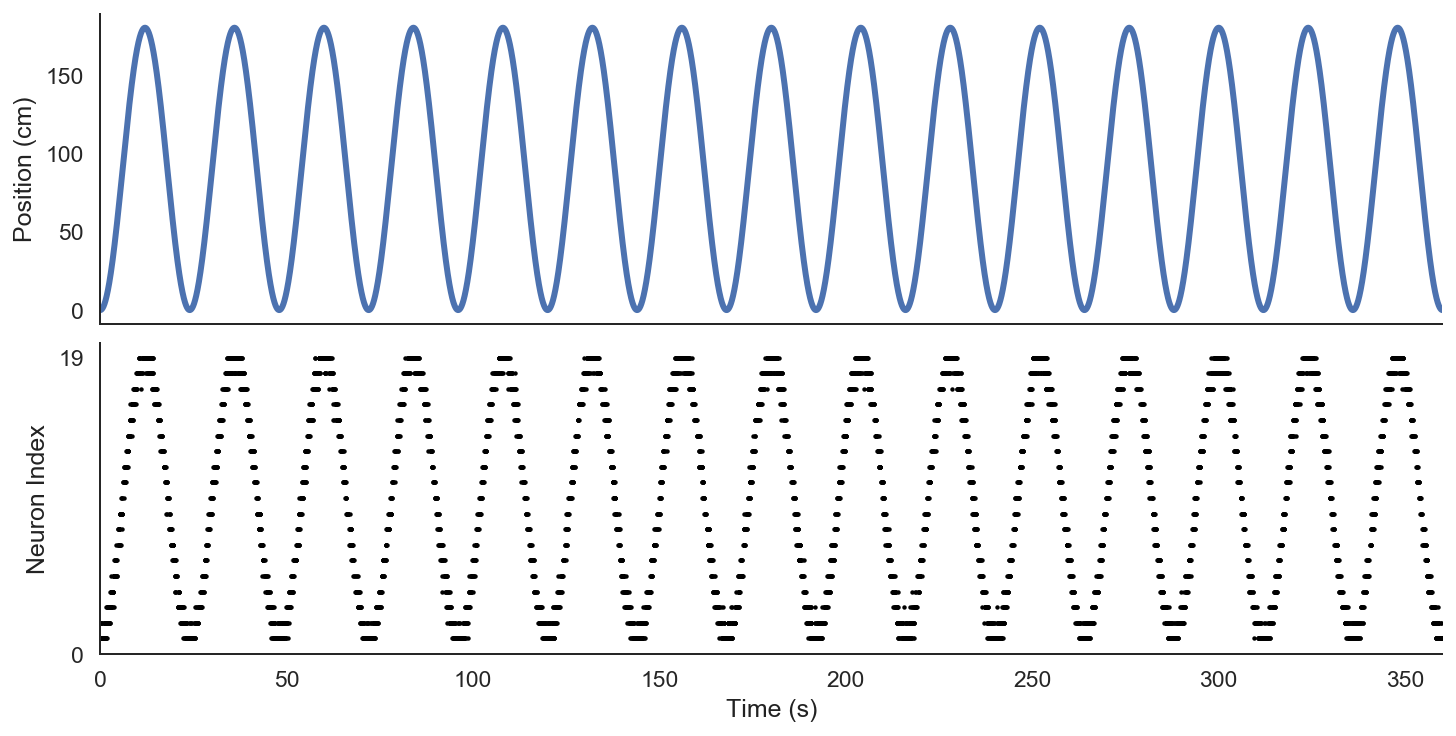

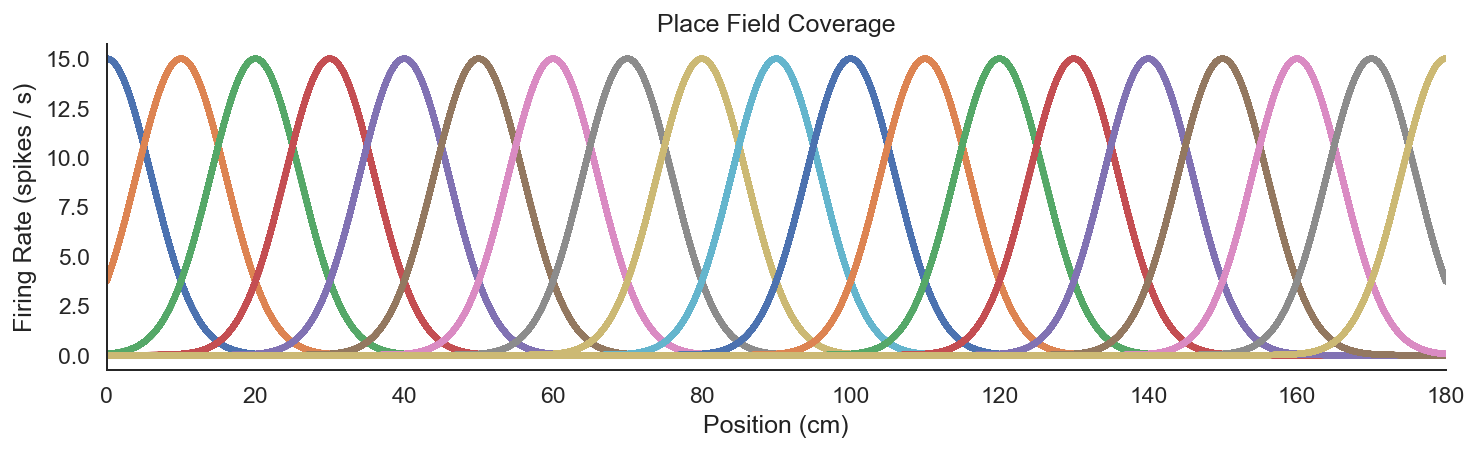

In [3]:
from src.sorted_spikes_simulation import make_simulated_run_data

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()
spike_ind, neuron_ind = np.nonzero(spikes)

fig, axes = plt.subplots(2,1, figsize=(10, 5), constrained_layout=True, sharex=True)
axes[0].plot(time, linear_distance, linewidth=3)
axes[0].set_ylabel('Position (cm)')

axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
axes[1].set_yticks((0, spikes.shape[1]))
axes[1].set_ylabel('Neuron Index')

sns.despine()
axes[-1].set_xlabel('Time (s)')
axes[-1].set_xlim((time.min(), time.max()))

plt.figure(figsize=(12, 3))
plt.plot(linear_distance, place_fields, linewidth=3)
plt.xlabel('Position (cm)')
plt.ylabel('Firing Rate (spikes / s)')
plt.title('Place Field Coverage')
plt.xlim((linear_distance.min(), linear_distance.max()))
sns.despine();

## Fit Sorted Spikes Classifier

In [4]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var))
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform', 'identity'], ['uniform', 'uniform', 'uniform'], ['random_walk', 'uniform', 'identity']],
            discrete_transition_diag=0.999,
            discrete_transition_type='strong_diagonal',
            infer_track_interior=True,
            initial_conditions_type='uniform_on_track', knot_spacing=10,
            movement_var=0.2775841643294233,
            place_bin_size=0.526862566832588, position_range=None,
            replay_speed=120, spike_model_penalty=0.5)

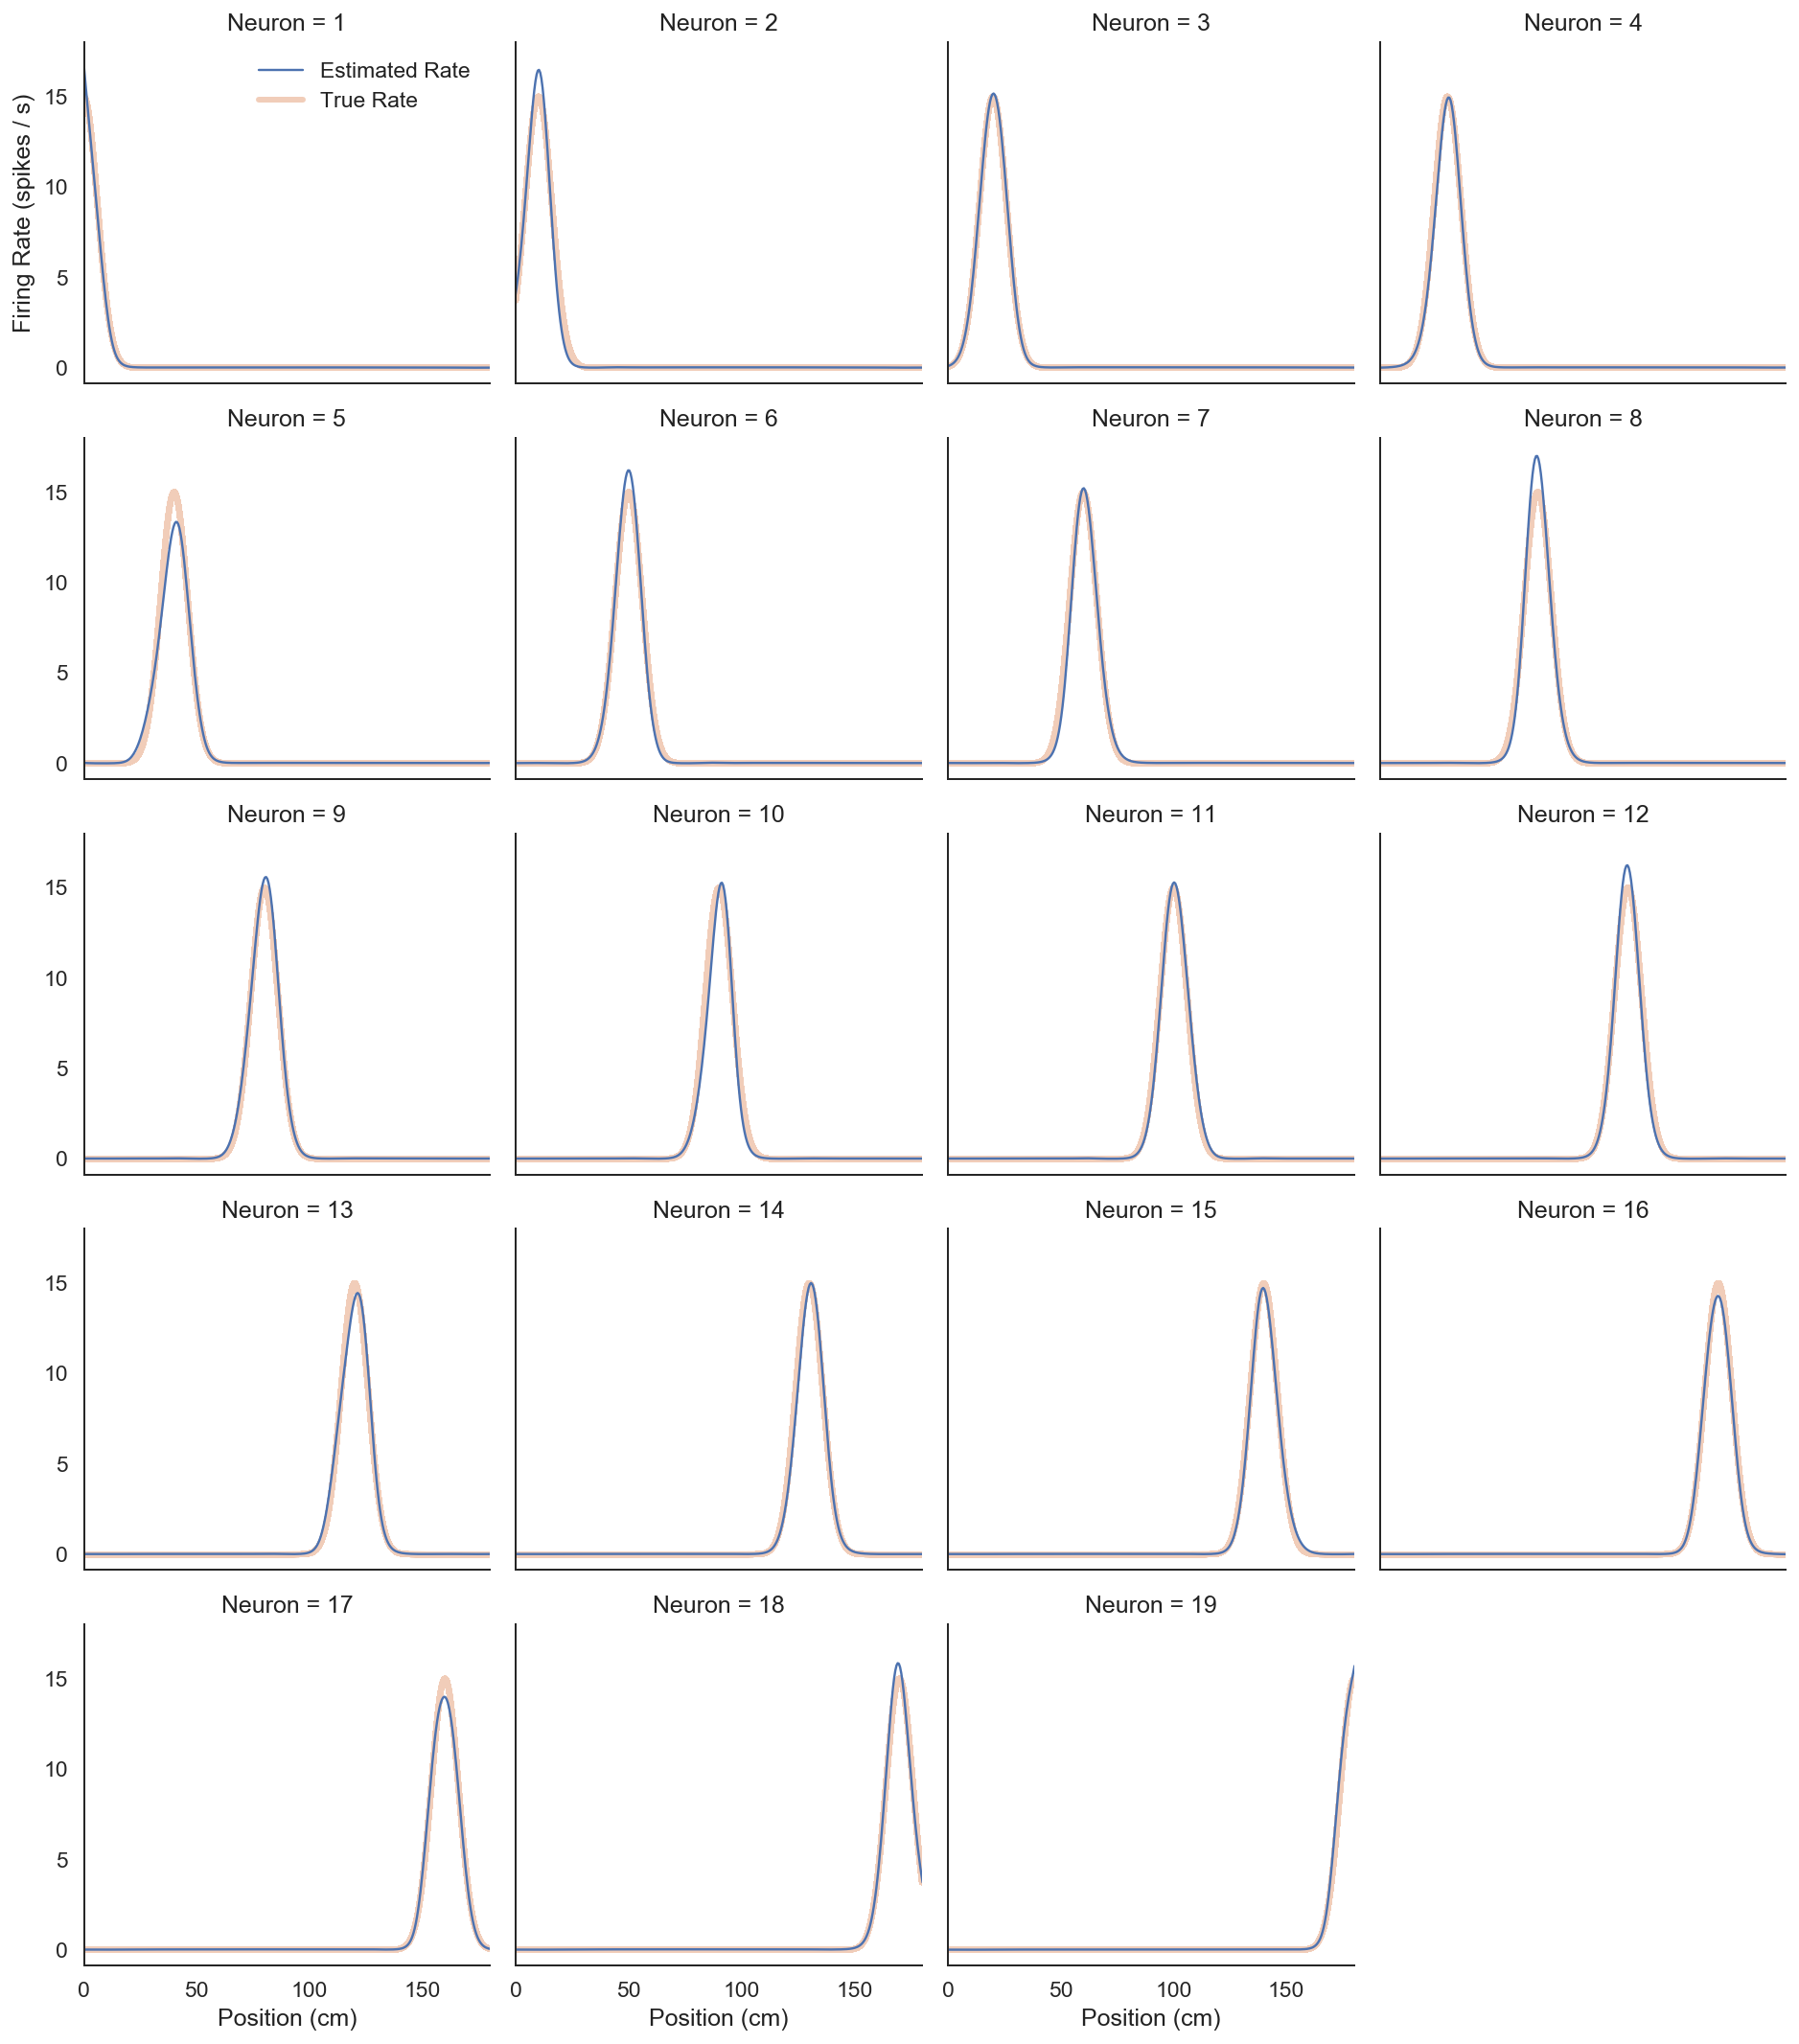

In [5]:
g = (classifier.place_fields_ * sampling_frequency).plot(x='position', col='neuron', col_wrap=4, label='Estimated Rate')
for ind, (ax, true_field) in enumerate(zip(g.axes.flat, place_fields.T)):
    ax.plot(linear_distance, true_field, linestyle='-',
            zorder=0, linewidth=3, alpha=0.4, label='True Rate')
    ax.set_xlim((linear_distance.min(), linear_distance.max()))
    ax.set_title(f'Neuron = {ind + 1}')
sns.despine()

g.axes[0, 0].set_ylabel('Firing Rate (spikes / s)')
g.axes[0, 0].legend(frameon=False)

for ax in g.axes[-1]:
    ax.set_xlabel('Position (cm)')

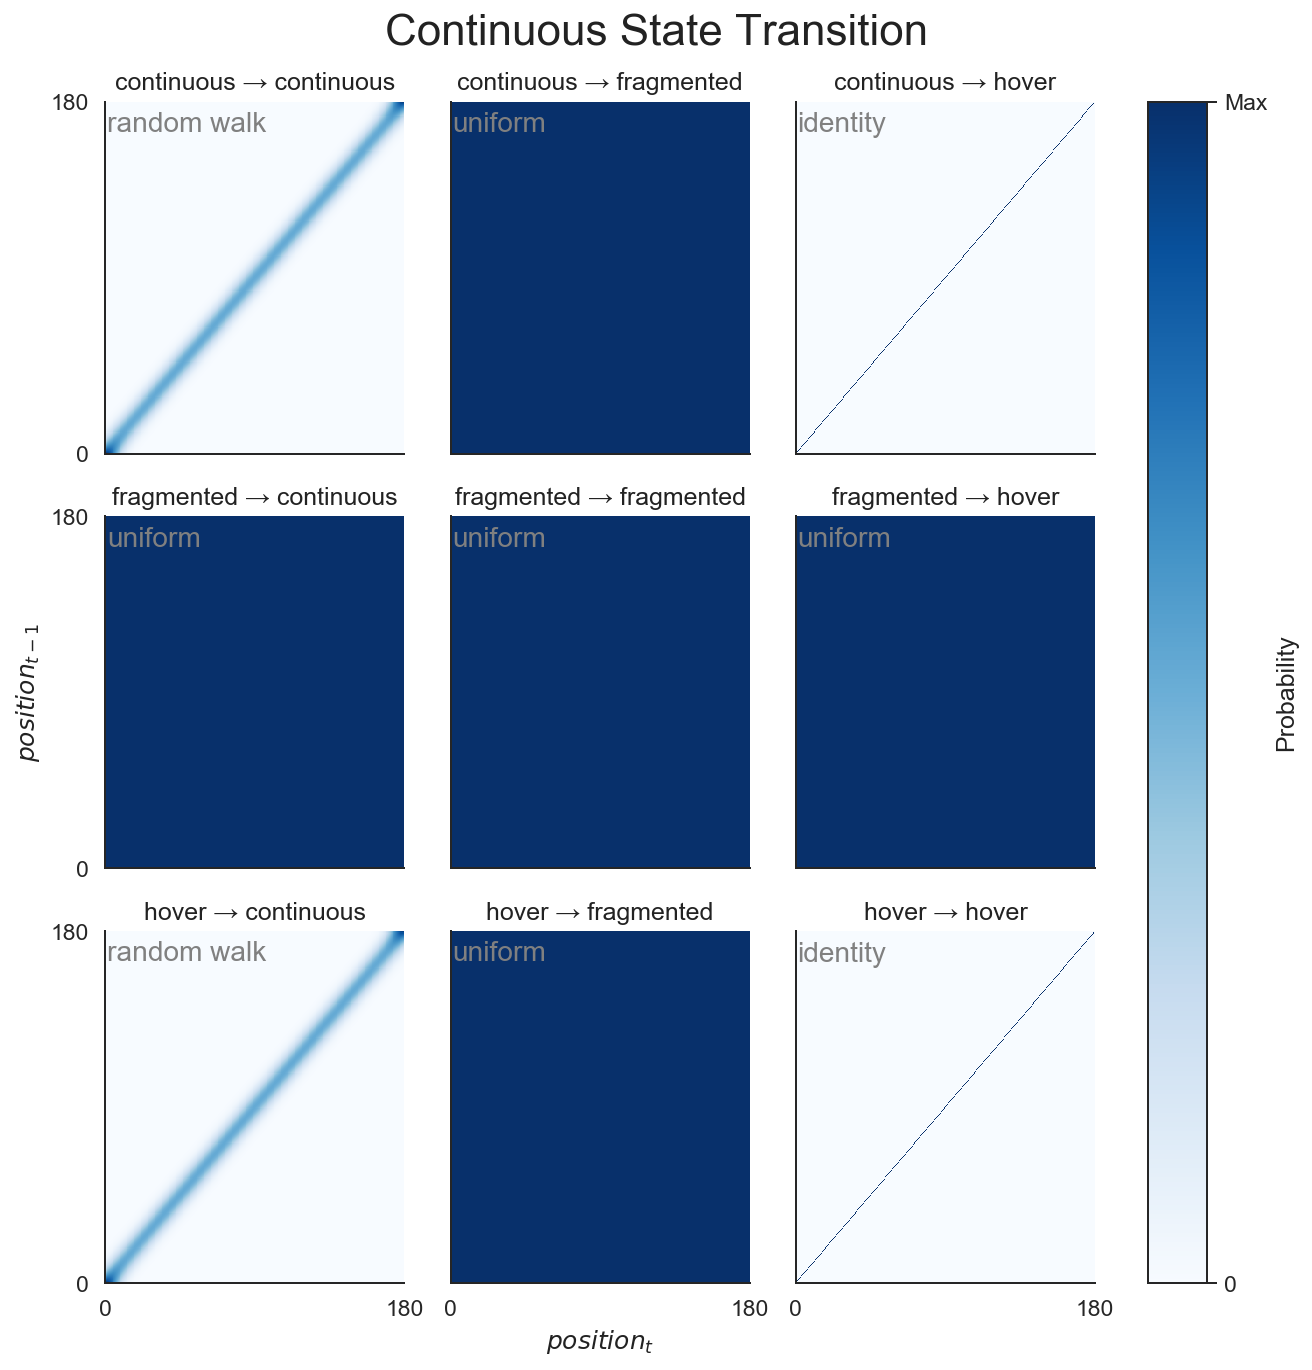

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9),
                         sharex=True, sharey=True,
                         constrained_layout=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)
x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
state_names = ['continuous', 'fragmented', 'hover']
bin_min, bin_max = linear_distance.min(), linear_distance.max()

for j in range(3):
    for k in range(3):
        im = axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues',
                                   vmin=0.0, vmax=classifier.continuous_state_transition_[j, k].max())
        axes[j, k].text(1, 175, continuous_transition_types[j, k].replace('_', ' '), color='grey',
                        va='top', fontsize=14)
        axes[j, k].set_title(f'{state_names[j]} → {state_names[k]}')
        axes[j, k].set_xticks((bin_min, bin_max))
        axes[j, k].set_yticks((bin_min, bin_max))
        
plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
axes[1, 0].set_ylabel(r'$position_{t-1}$')
axes[-1, 1].set_xlabel(r'$position_{t}$')
plt.suptitle('Continuous State Transition', y=1.04, fontsize=22)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1], label='Probability')
cbar.ax.set_yticklabels(['0', 'Max'])
sns.despine()

Text(0.5, 1.0, 'Discrete State Transition')

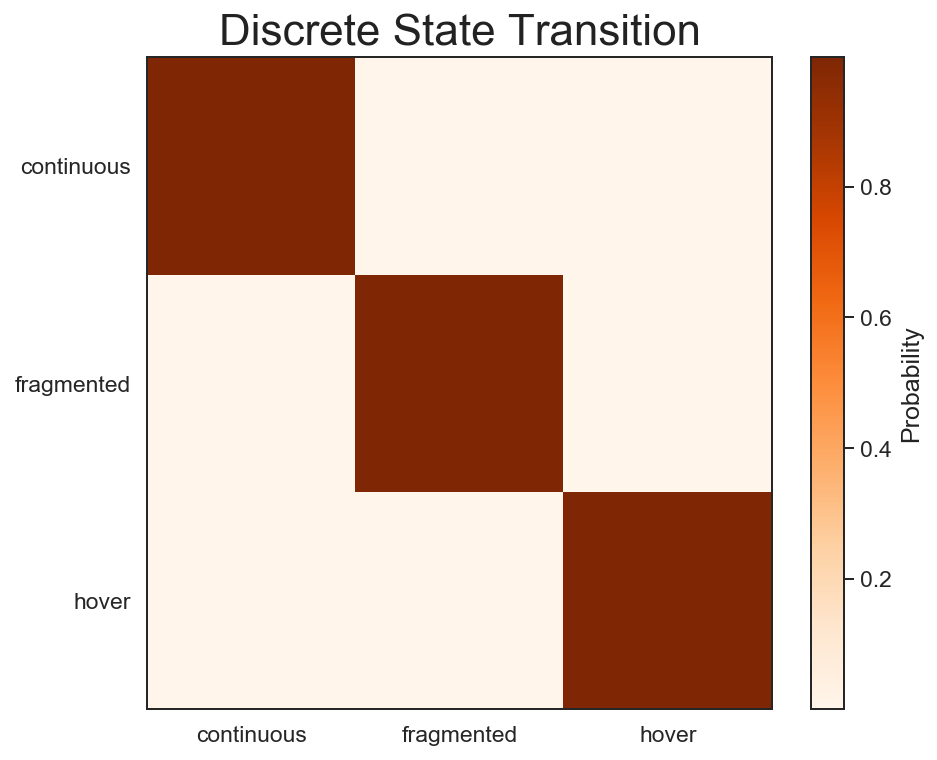

In [7]:
state_names = ['continuous', 'fragmented', 'hover']
edges = np.arange(0.5, 4.5)
x_edges, y_edges = np.meshgrid(edges, edges)
plt.figure(figsize=(7, 6))
plt.pcolormesh(x_edges, y_edges, np.fliplr(classifier.discrete_state_transition_), cmap='Oranges')
plt.xticks(ticks=range(1, 4), labels=state_names)
plt.yticks(ticks=range(1, 4), labels=state_names[::-1])
plt.colorbar(label='Probability')
plt.title('Discrete State Transition', fontsize=22)

## Test classifier on different replay types 

In [8]:
def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black')
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    results.acausal_posterior.sum('position').plot(
        x='time', hue='state', ax=axes[1], linewidth=3)
    axes[1].set_ylabel('Probability')
    axes[1].set_ylim((0.0, 1.05))
    results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, vmin=0.0)
    plt.xlim((replay_time.min(), replay_time.max()))
    sns.despine()

### Continuous

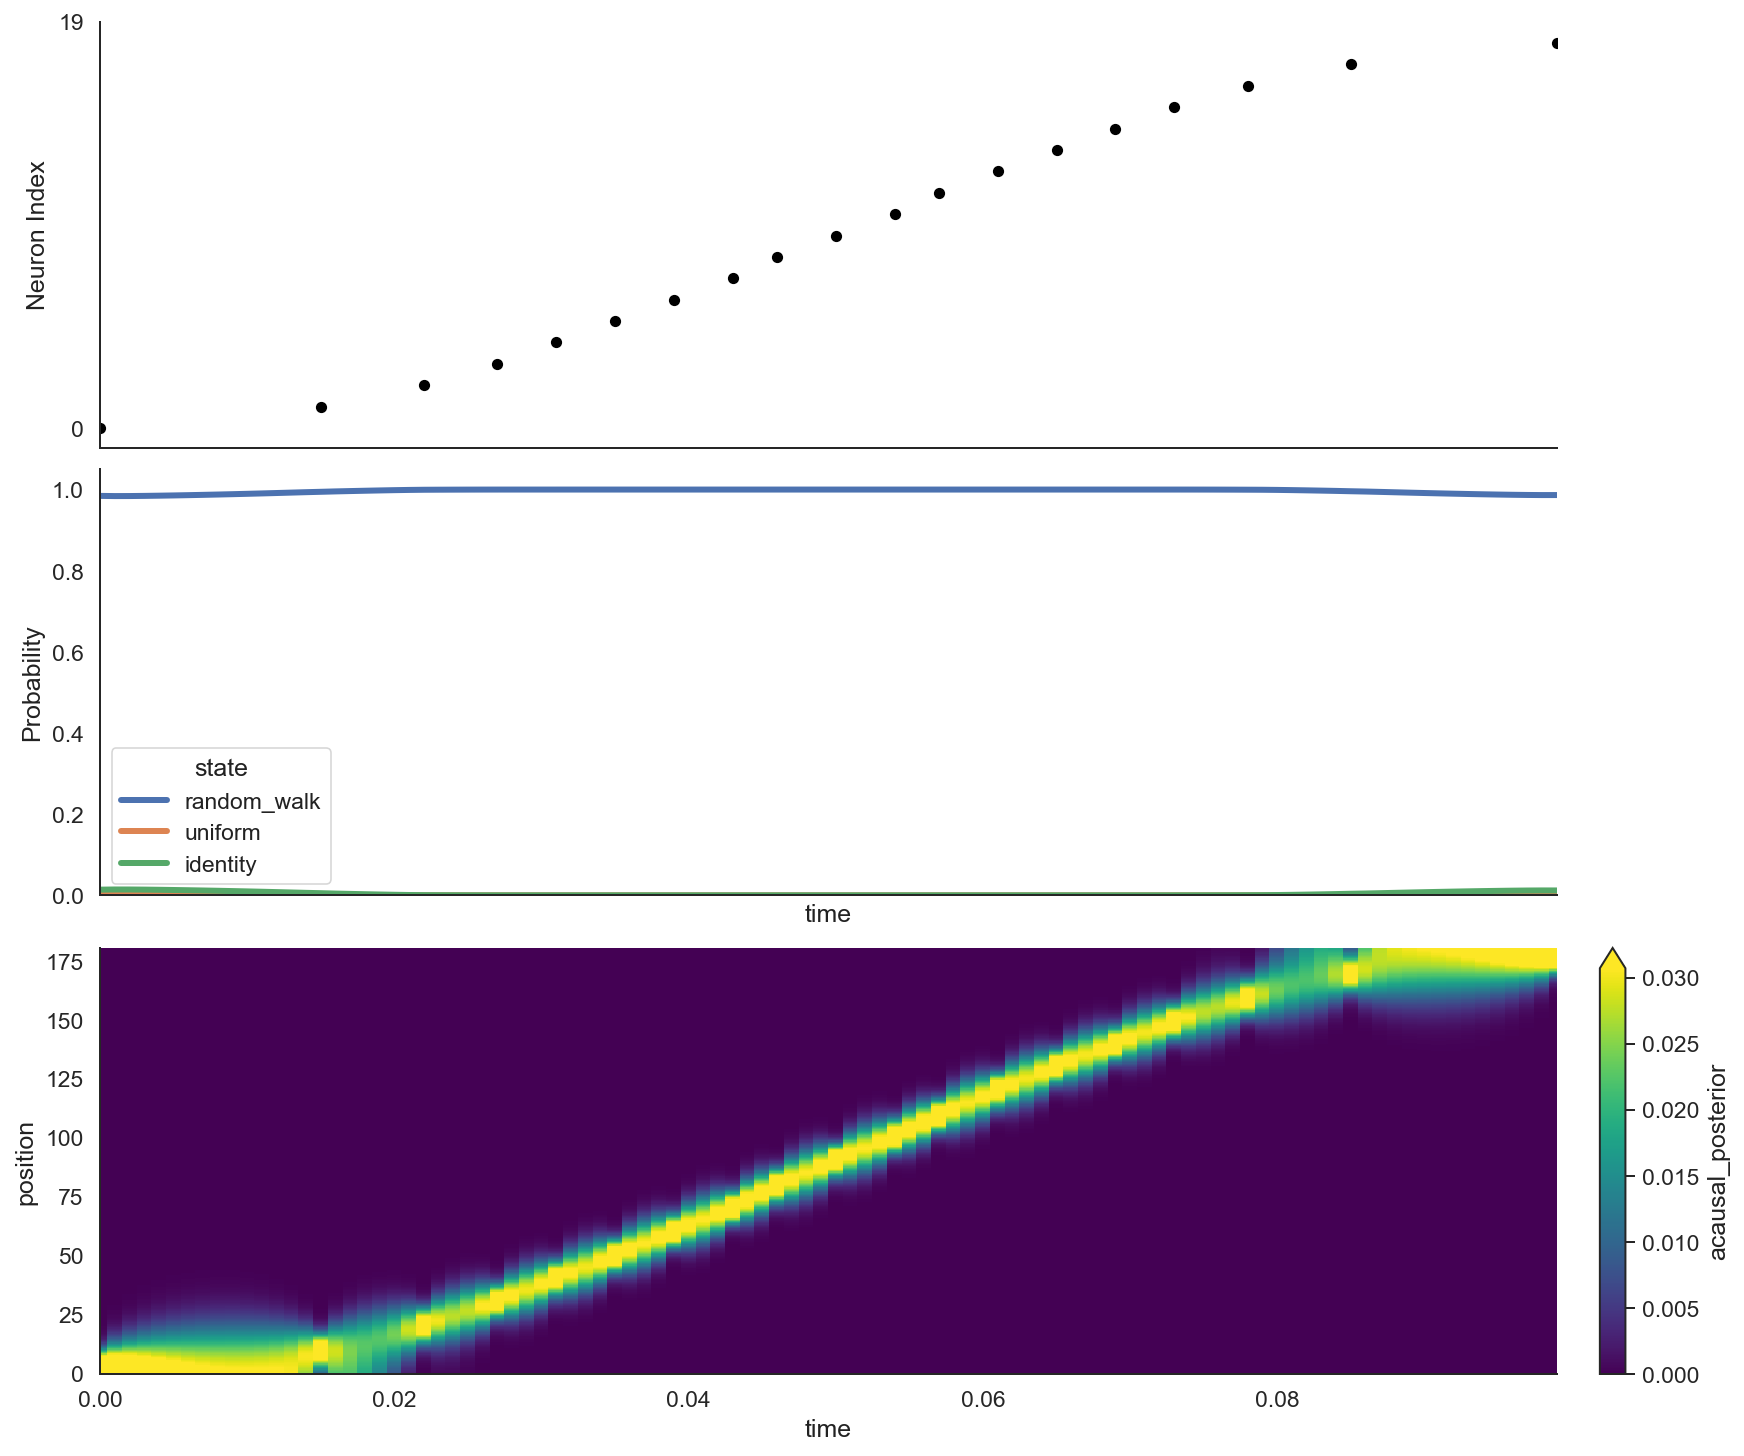

In [9]:
from src.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

### Hover

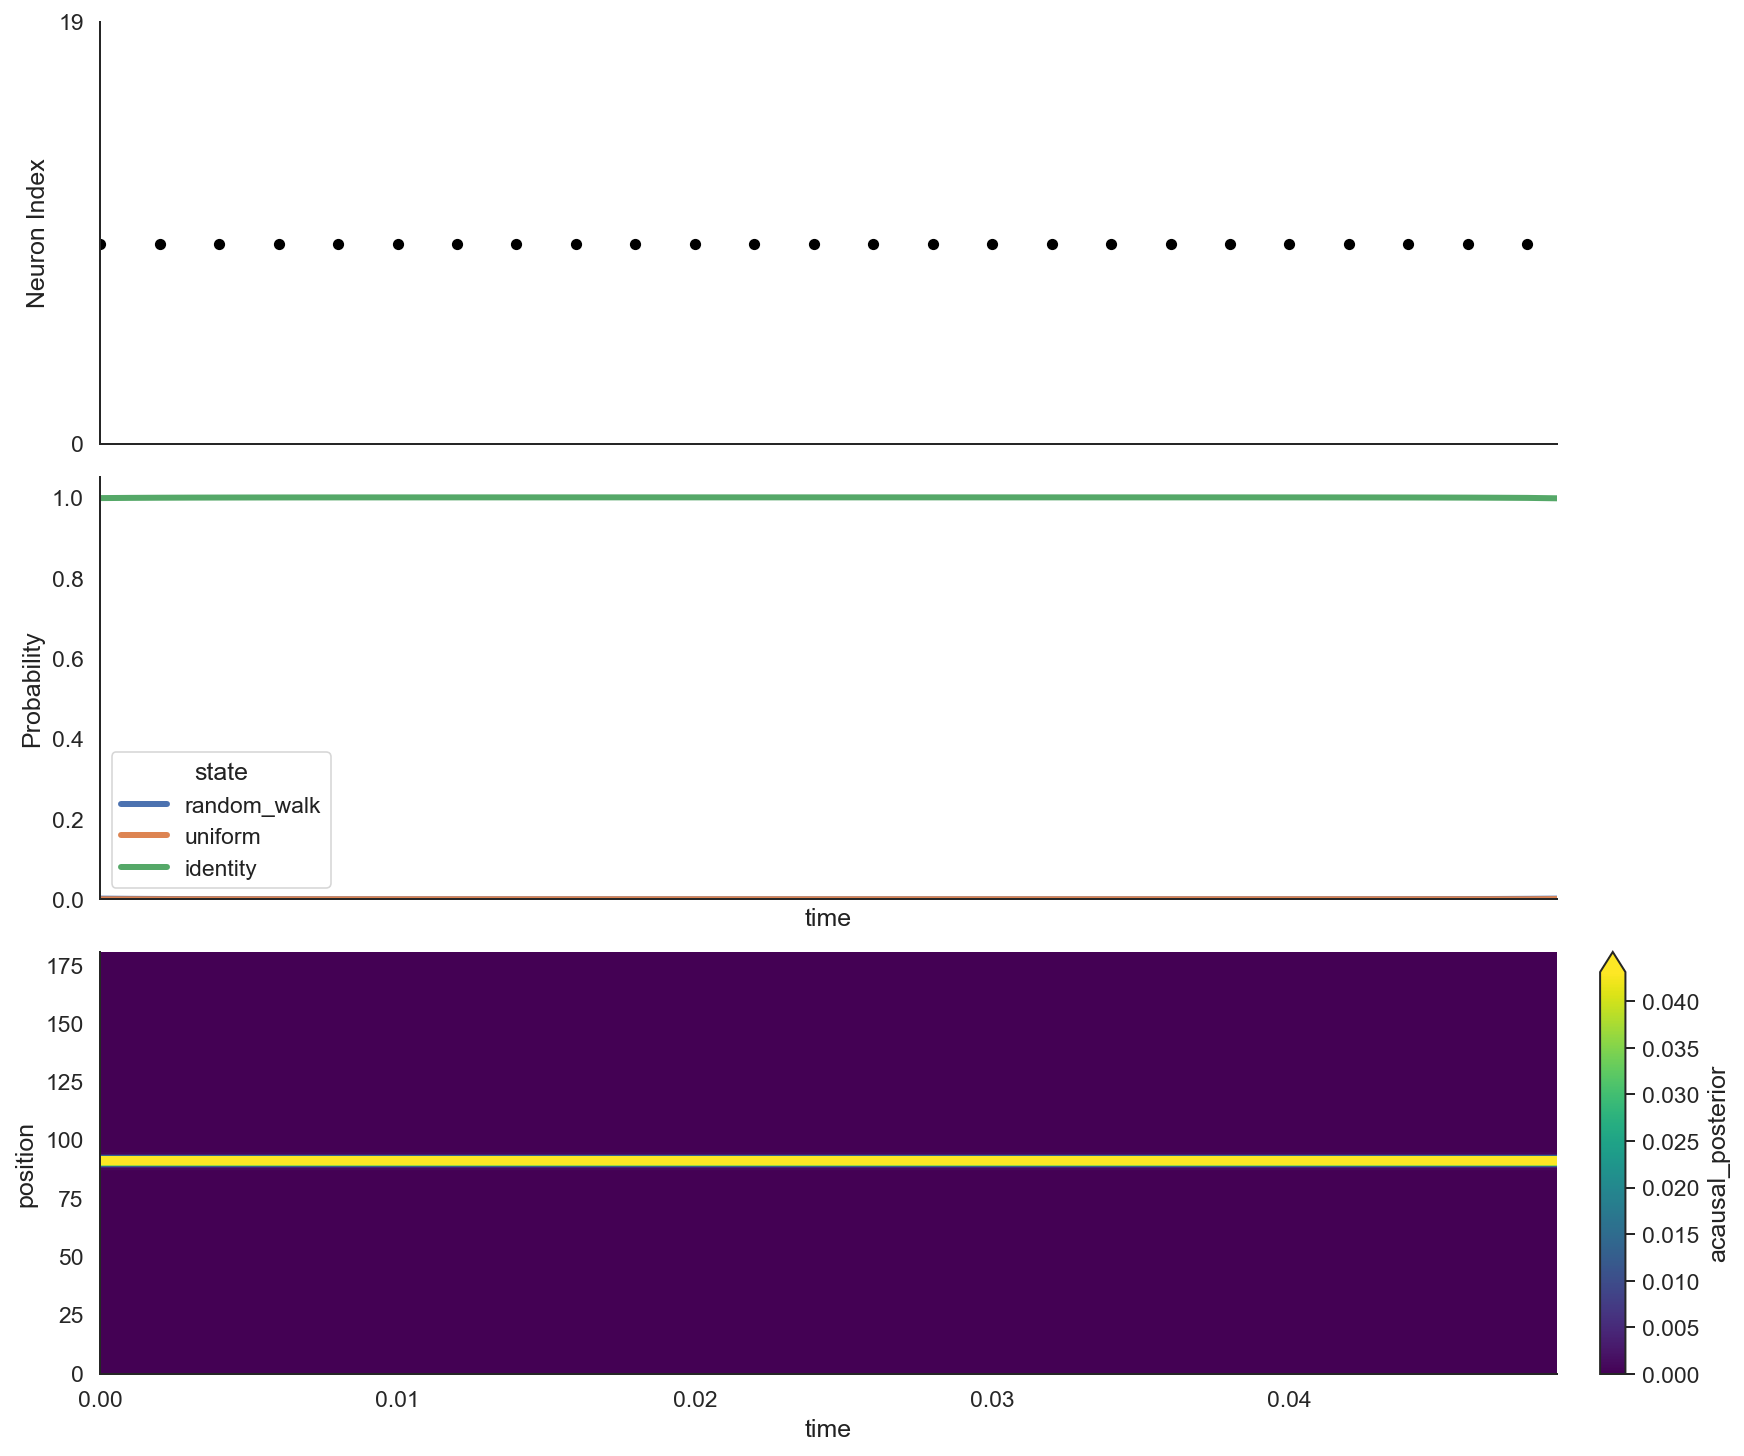

In [10]:
from src.sorted_spikes_simulation import make_hover_replay

replay_time, test_spikes = make_hover_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

### Fragmented

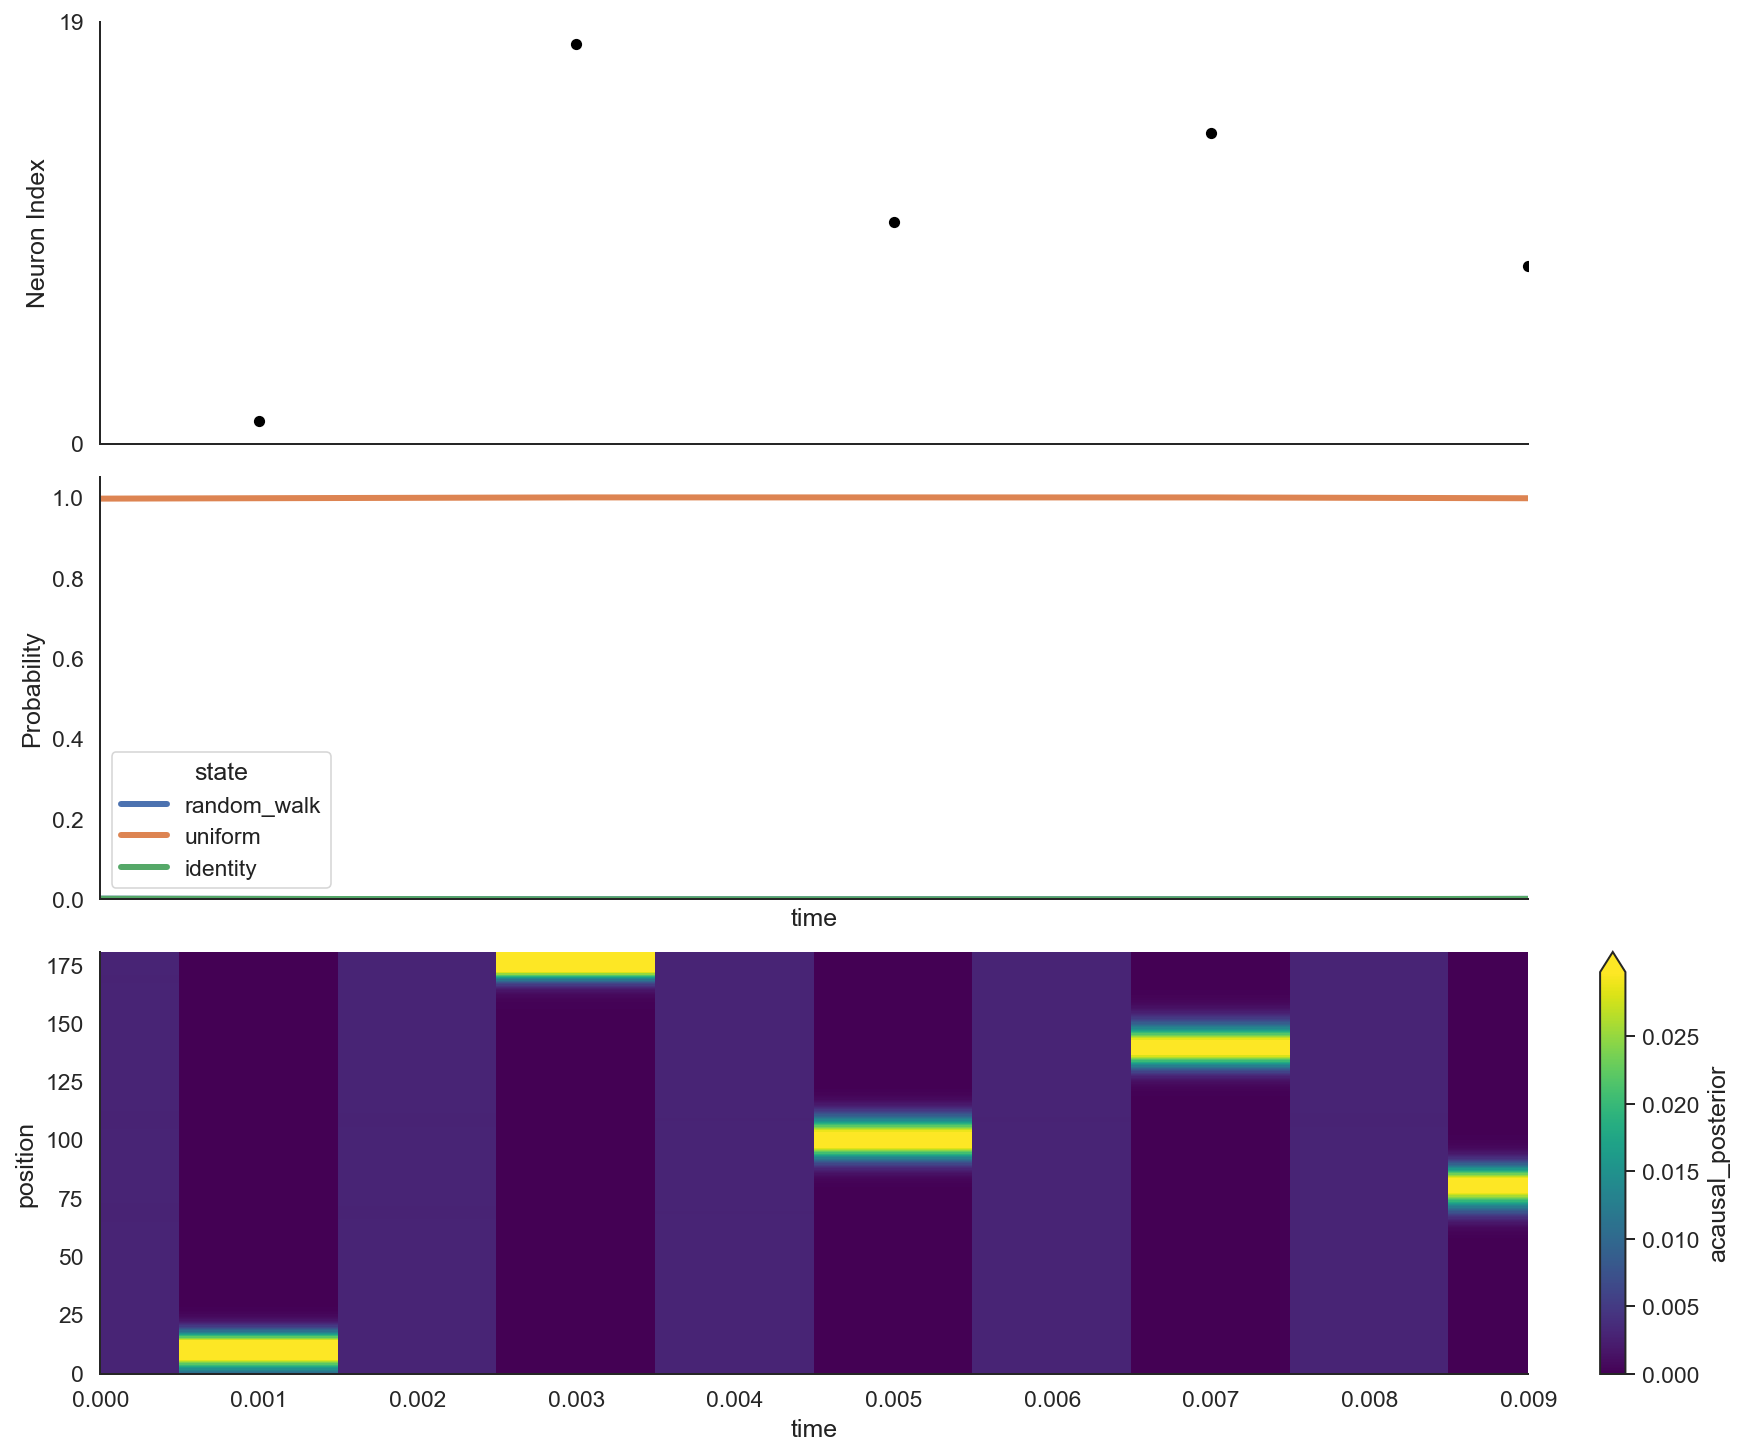

In [11]:
from src.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

### Hover-Continuous-Hover 

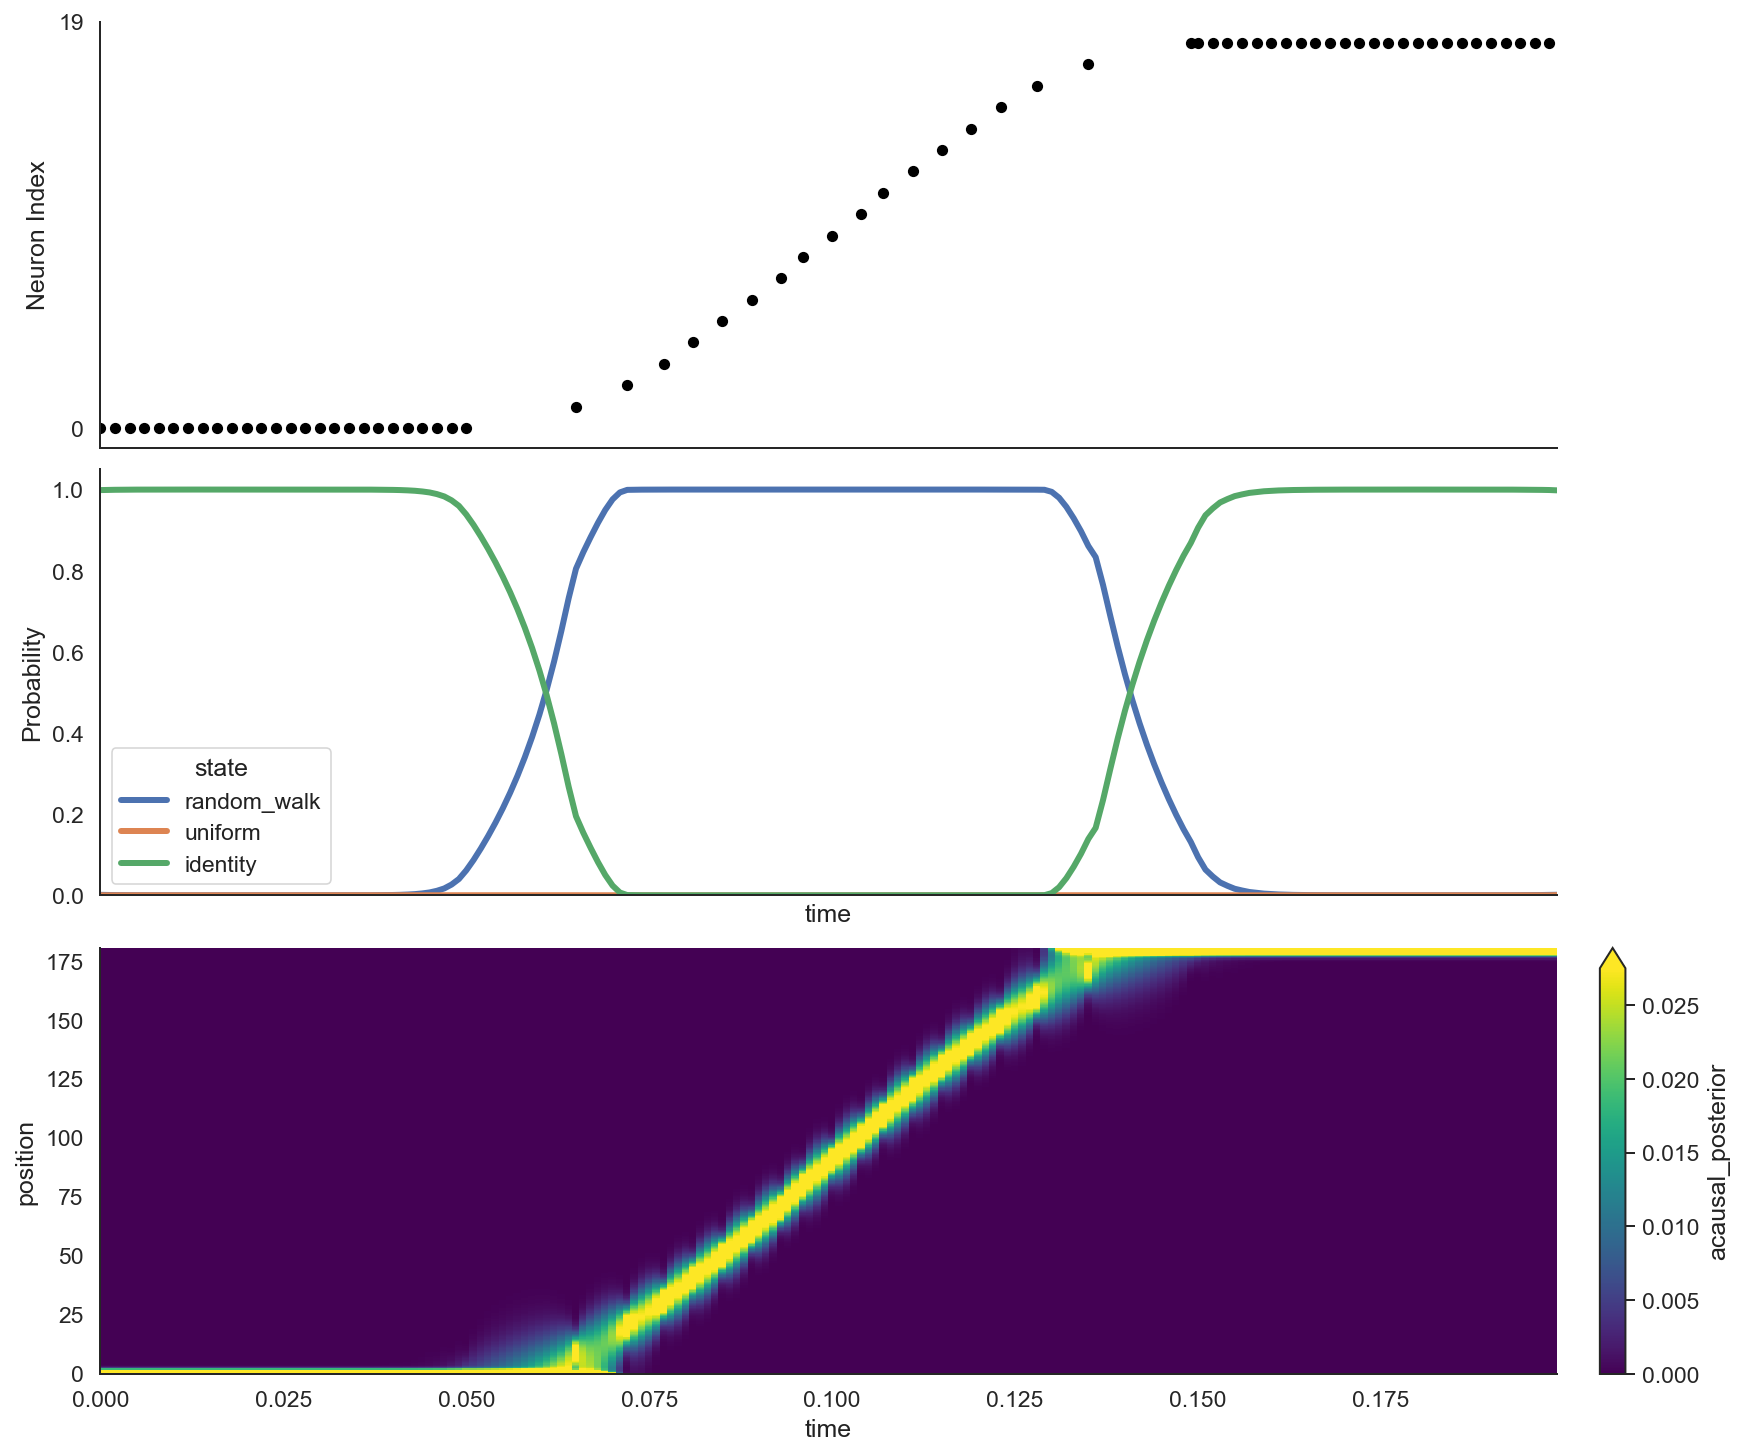

In [12]:
from src.sorted_spikes_simulation import make_hover_continuous_hover_replay

replay_time, test_spikes = make_hover_continuous_hover_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Hover-Fragmented

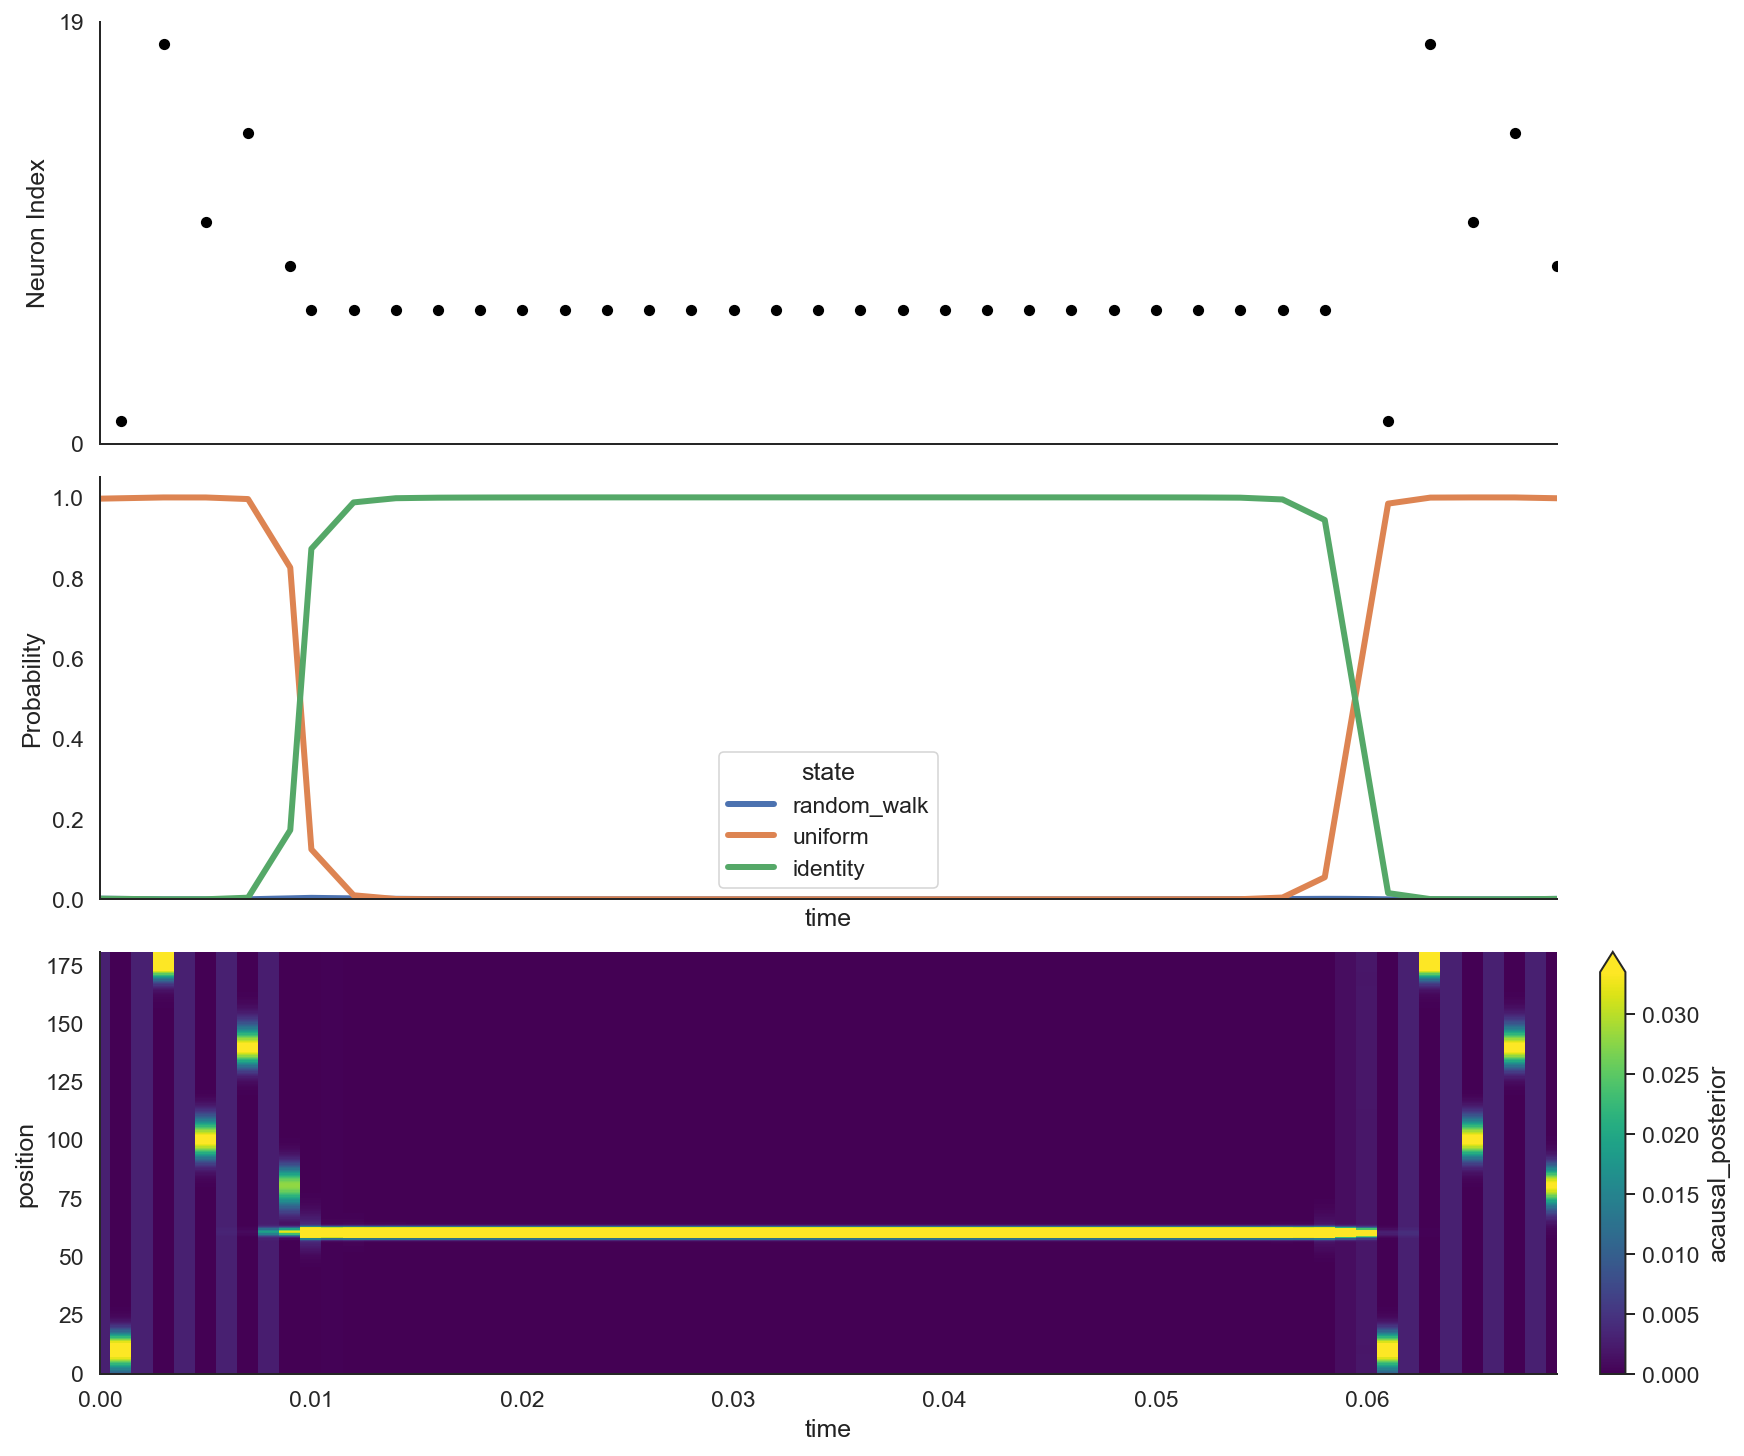

In [13]:
from src.sorted_spikes_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Continuous-Fragmented

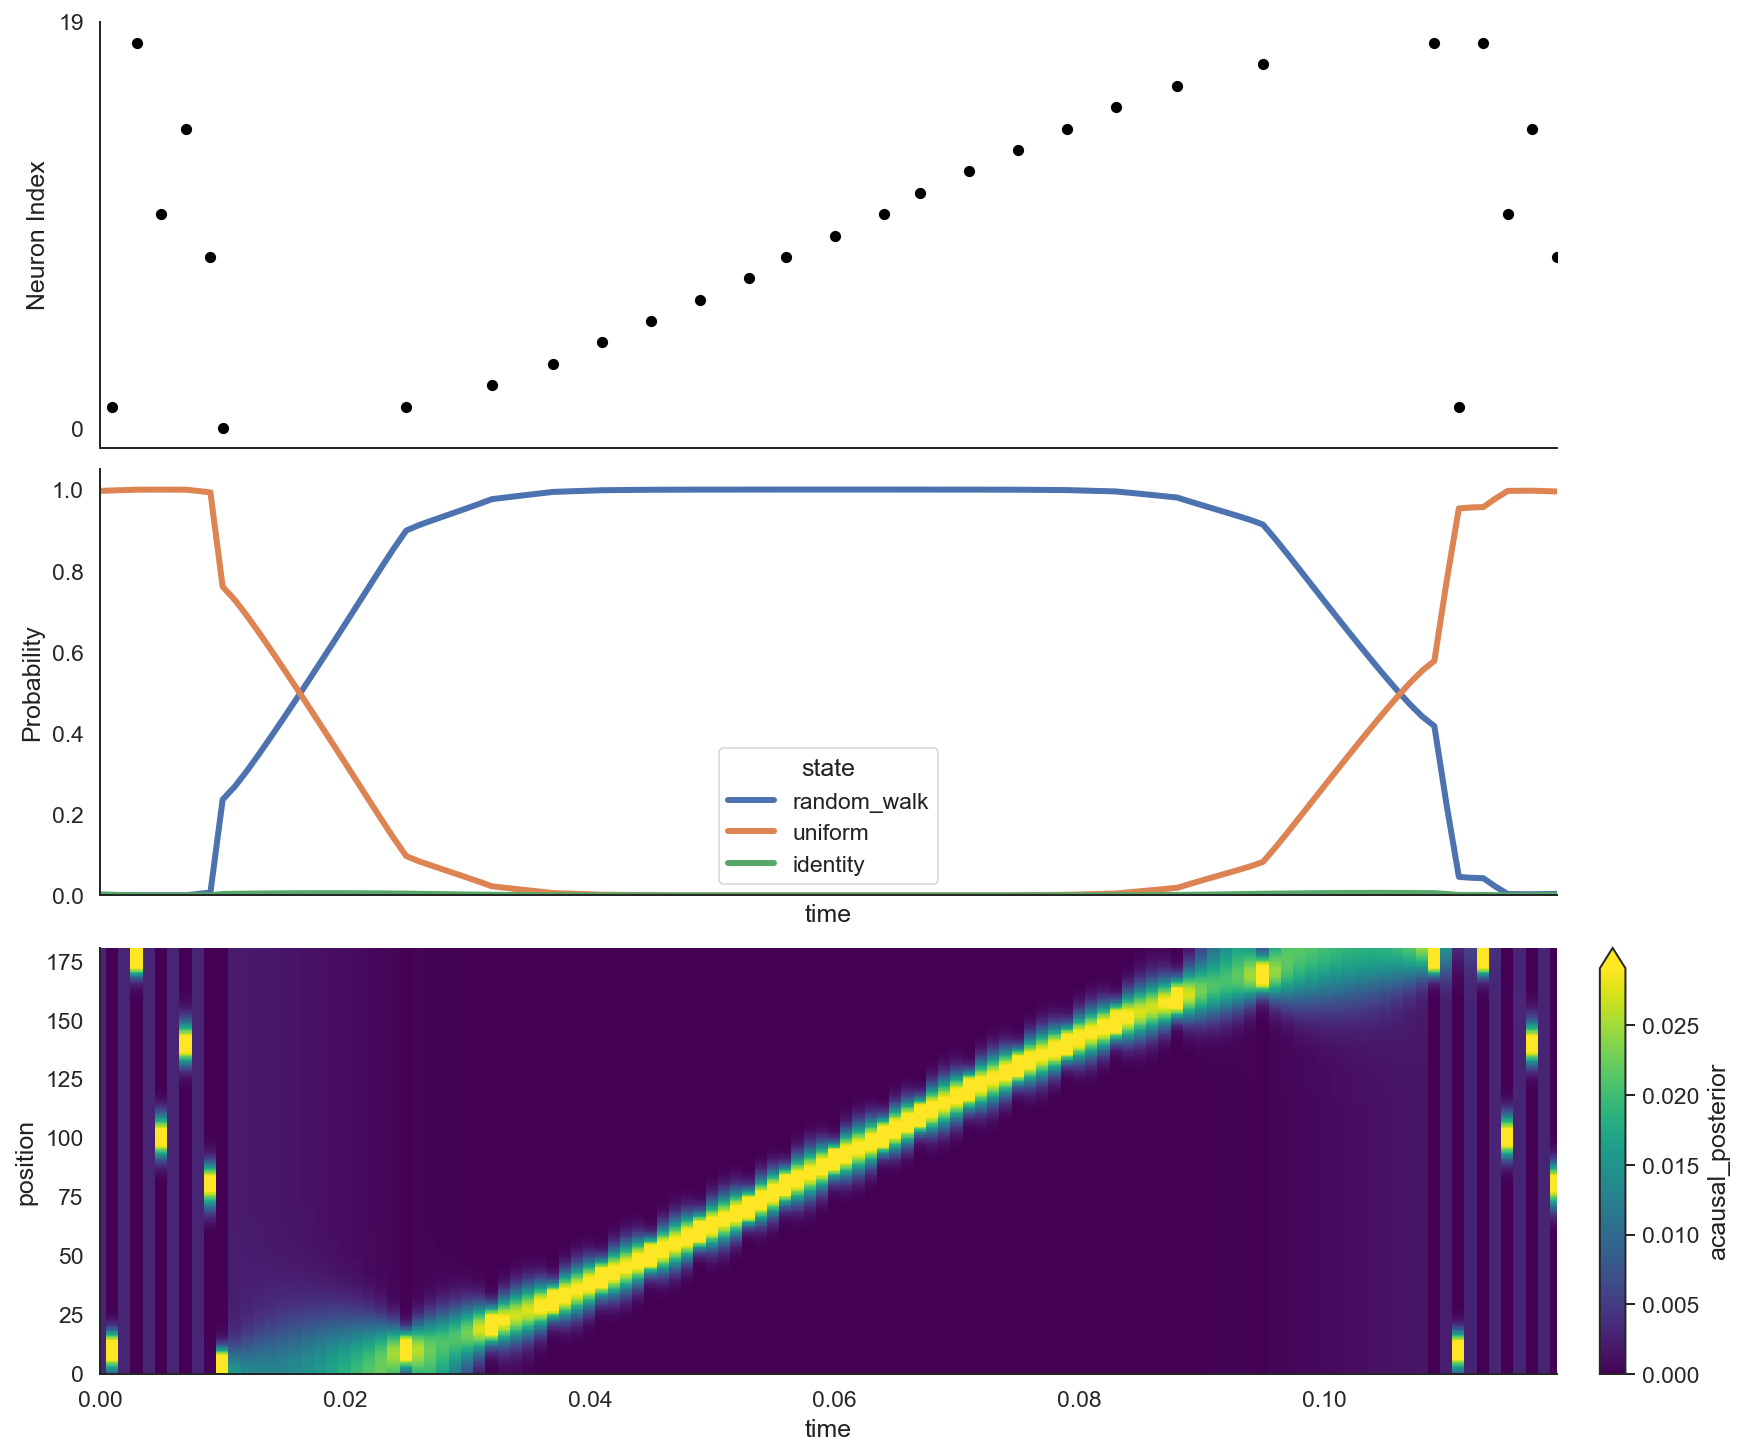

In [14]:
from src.sorted_spikes_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

## Explore State Transition Parameters on Hover-Continuous-Hover

In [15]:
replay_time, test_spikes = make_hover_continuous_hover_replay()

def plot_replay_probability(replay_time, results, diag):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True, sharex=True)
    results.acausal_posterior.sum('position').plot(
        x='time', hue='state', ax=ax, linewidth=3, add_legend=False)
    plt.xlim((replay_time.min(), replay_time.max()))
    plt.ylabel('Probability')
    plt.ylim((0.0, 1.05))
    plt.title(f'discrete state transition diagonal = {diag}', fontsize=16)
    sns.despine()

### All states equally likely

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


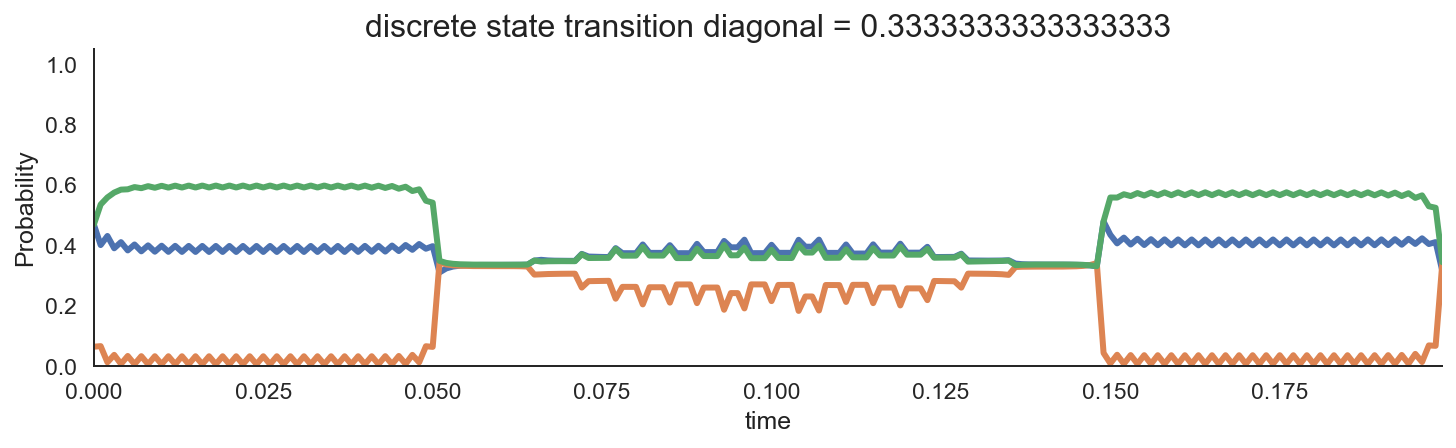

In [16]:
diag = 1/3

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    place_bin_size=np.sqrt(movement_var),
                                    continuous_transition_types=continuous_transition_types,
                                    discrete_transition_diag=diag)
classifier.fit(linear_distance, spikes)
results = classifier.predict(test_spikes, replay_time)
plot_replay_probability(replay_time, results, diag)

### Test diagonal strength from 0.4 - 0.9

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:

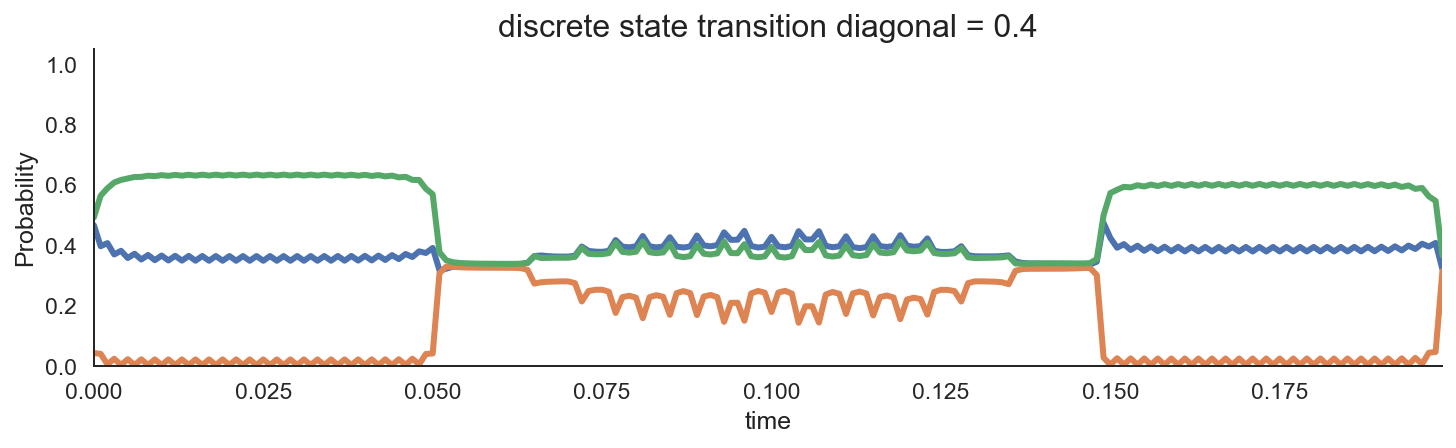

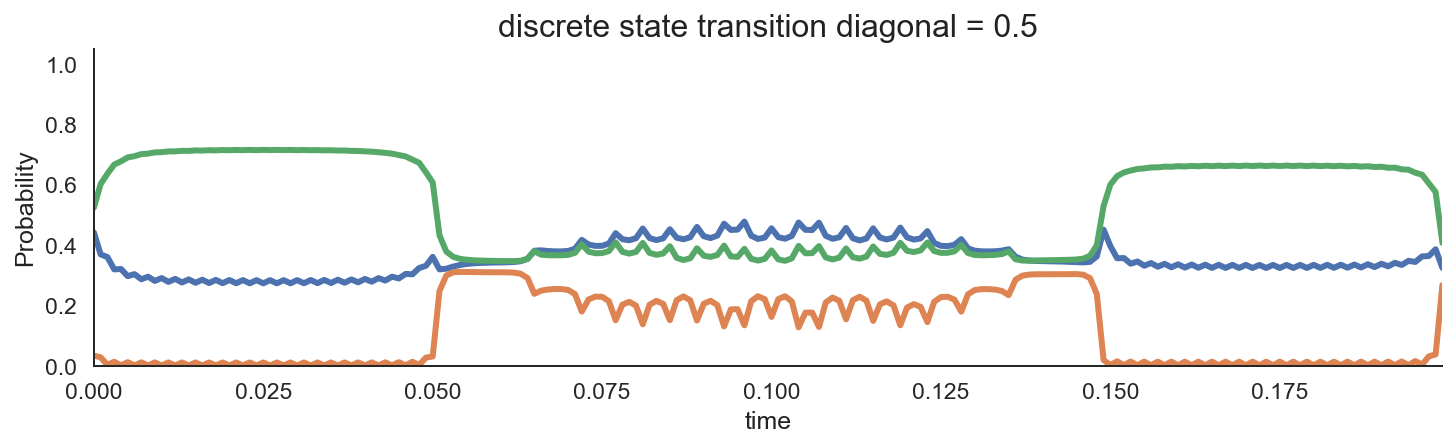

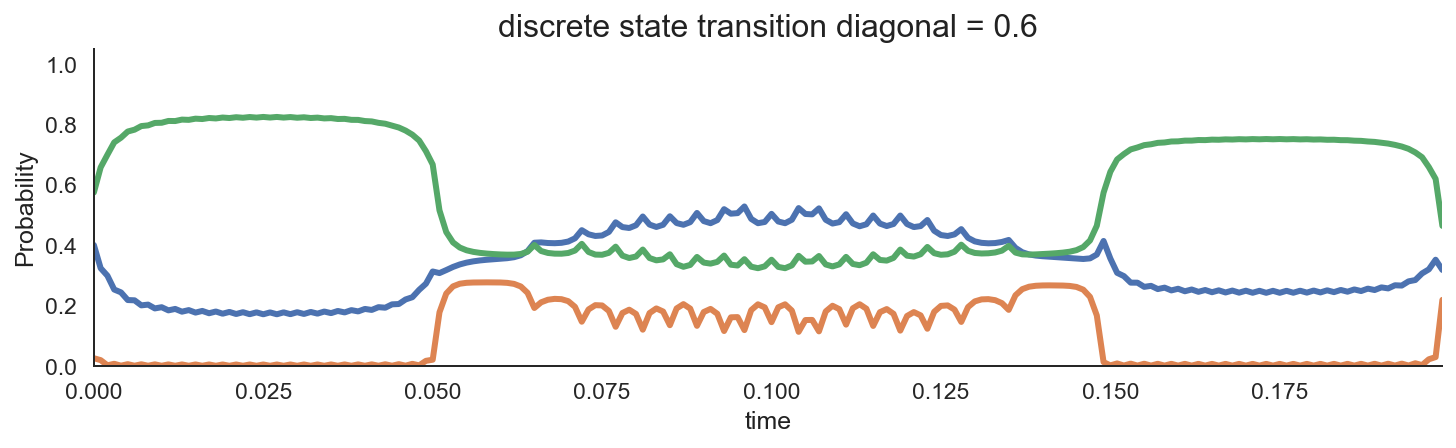

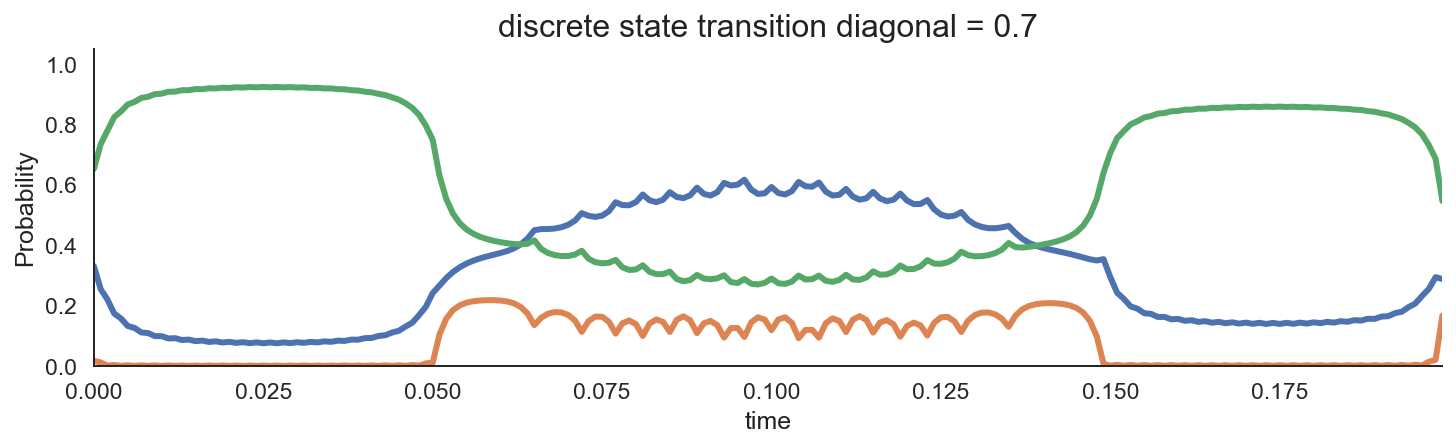

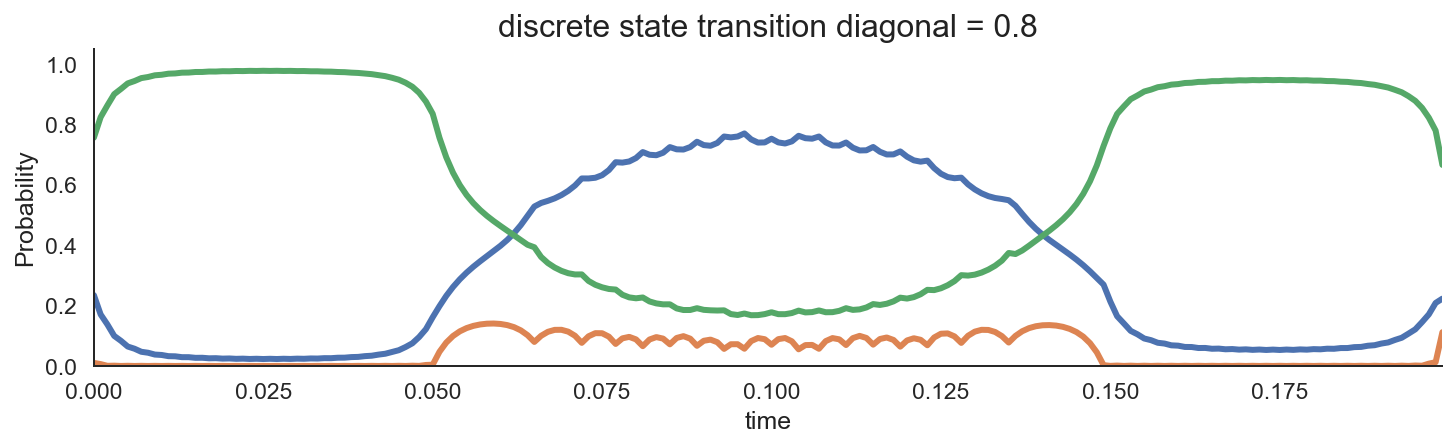

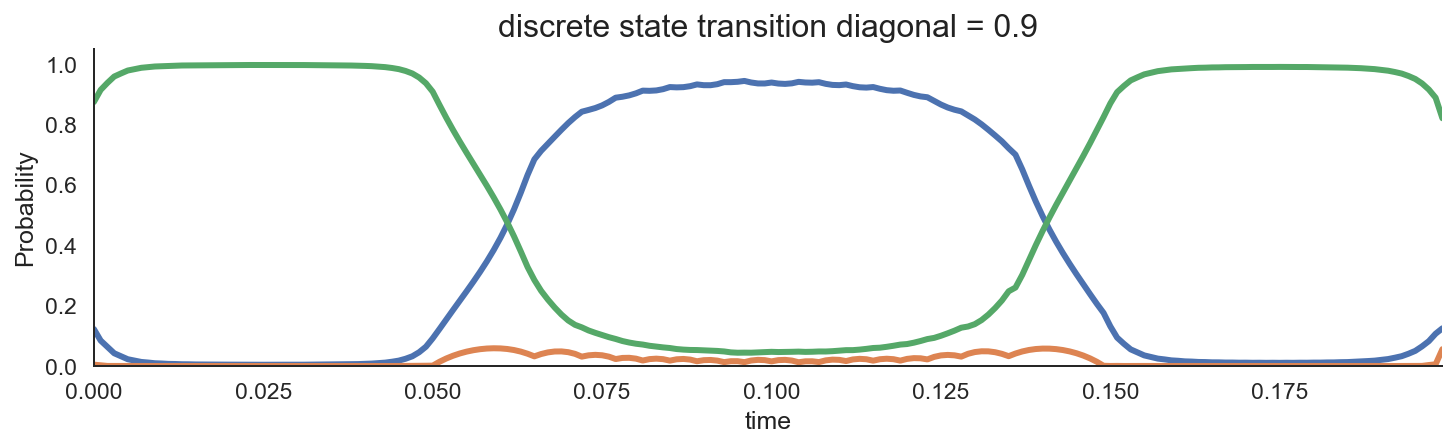

In [17]:
diags = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for diag in diags:
    classifier = SortedSpikesClassifier(movement_var=movement_var,
                                        replay_speed=120,
                                        spike_model_penalty=0.5,
                                        place_bin_size=np.sqrt(movement_var),
                                        continuous_transition_types=continuous_transition_types,
                                        discrete_transition_diag=diag)
    classifier.fit(linear_distance, spikes)
    results = classifier.predict(test_spikes, replay_time)
    plot_replay_probability(replay_time, results, diag)

### Test diagonal strength from 0.99 - 0.999999999

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:

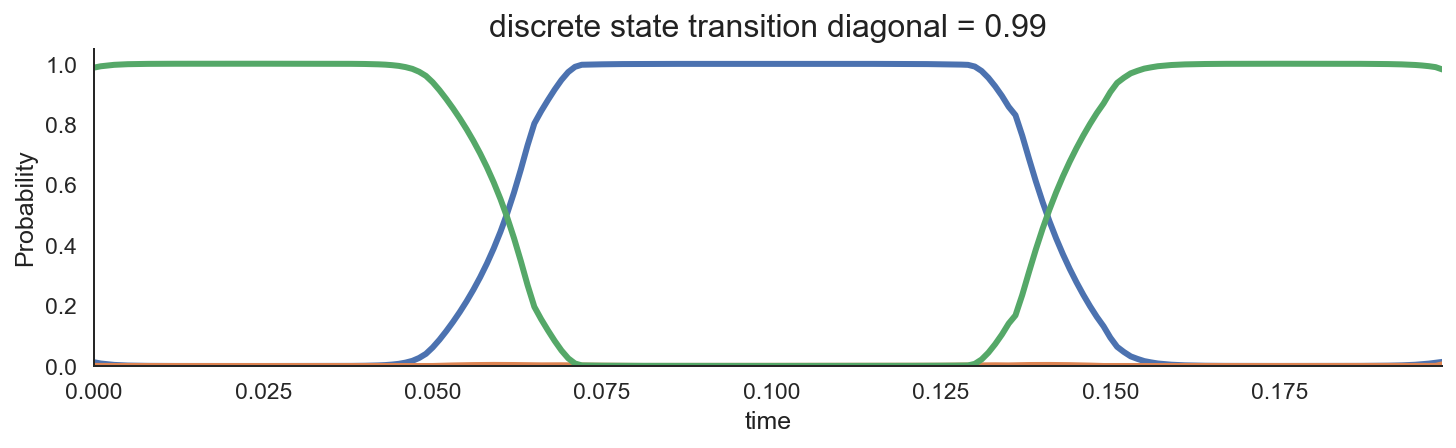

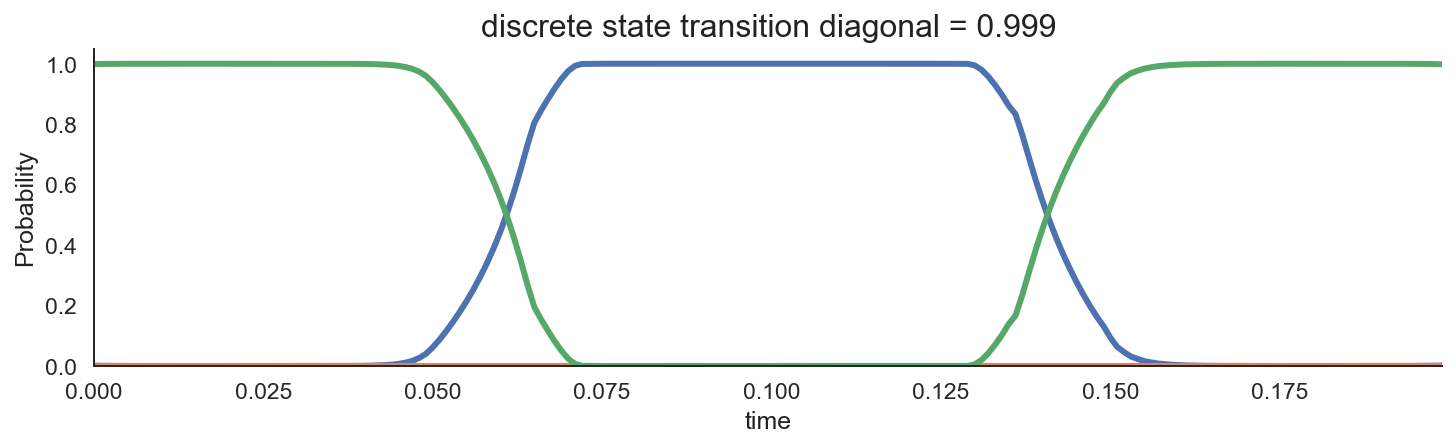

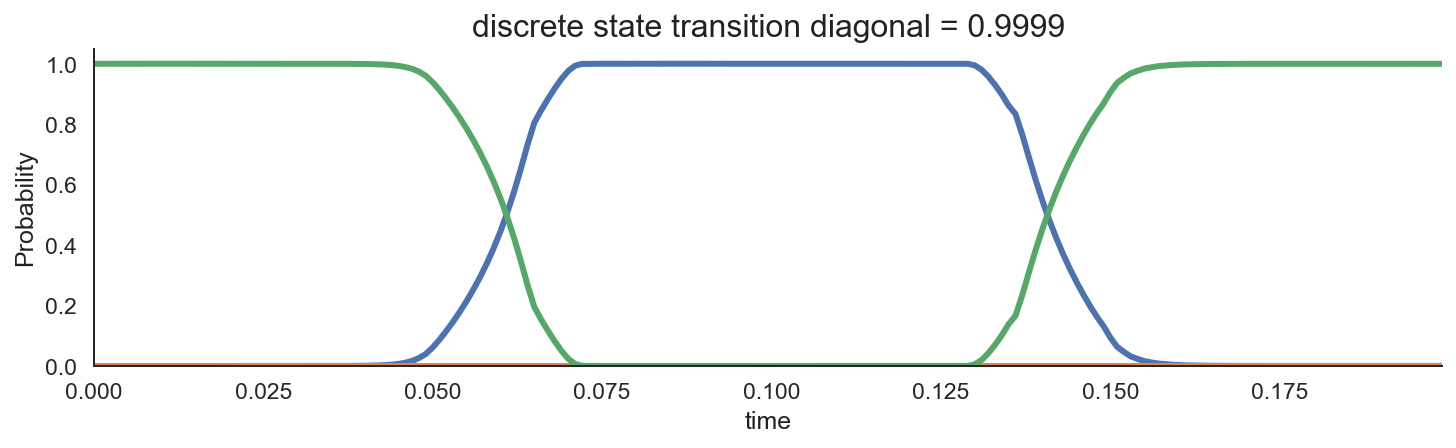

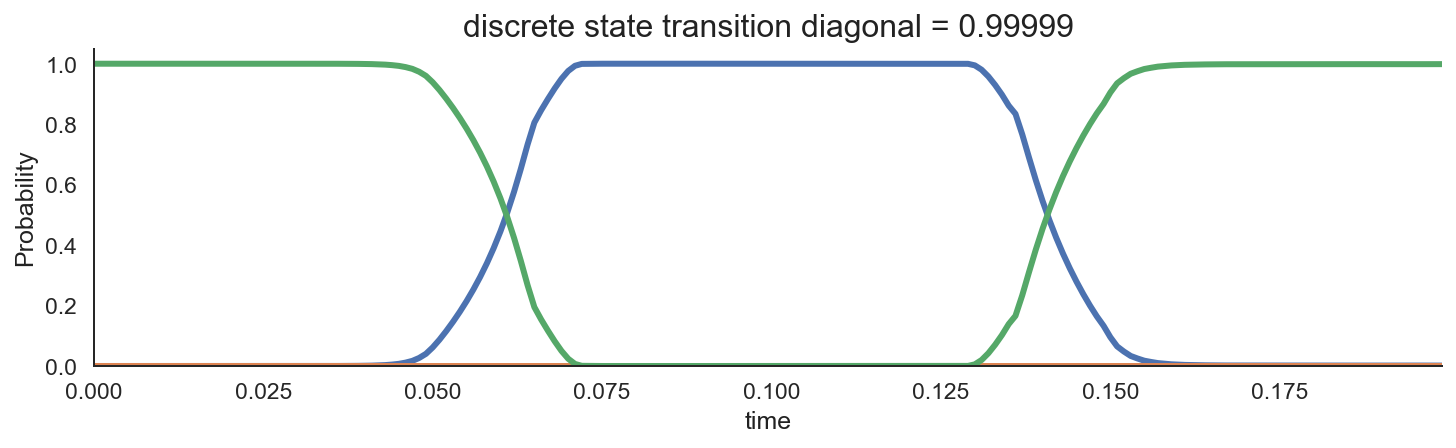

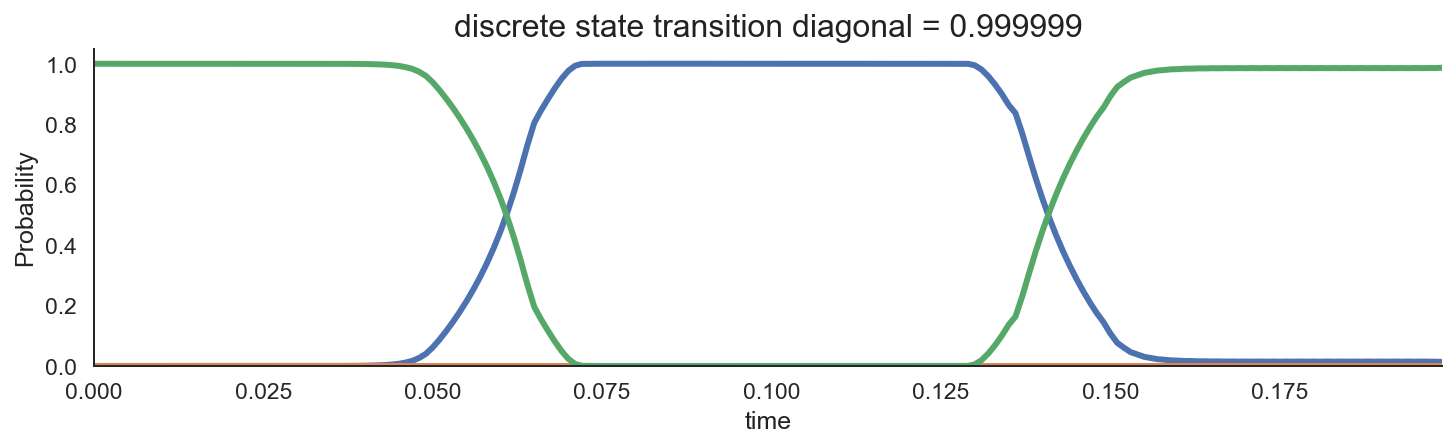

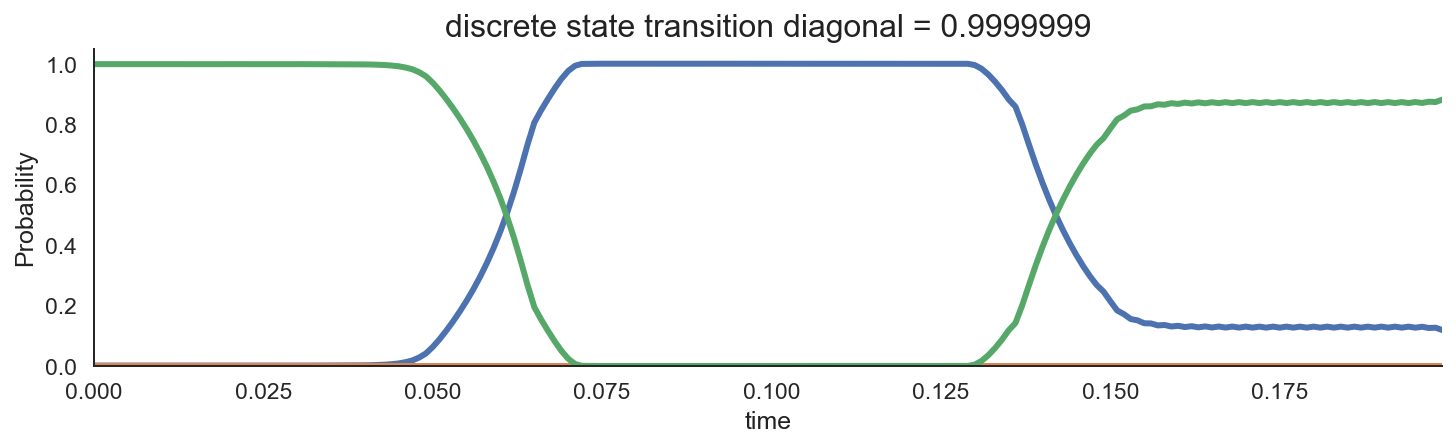

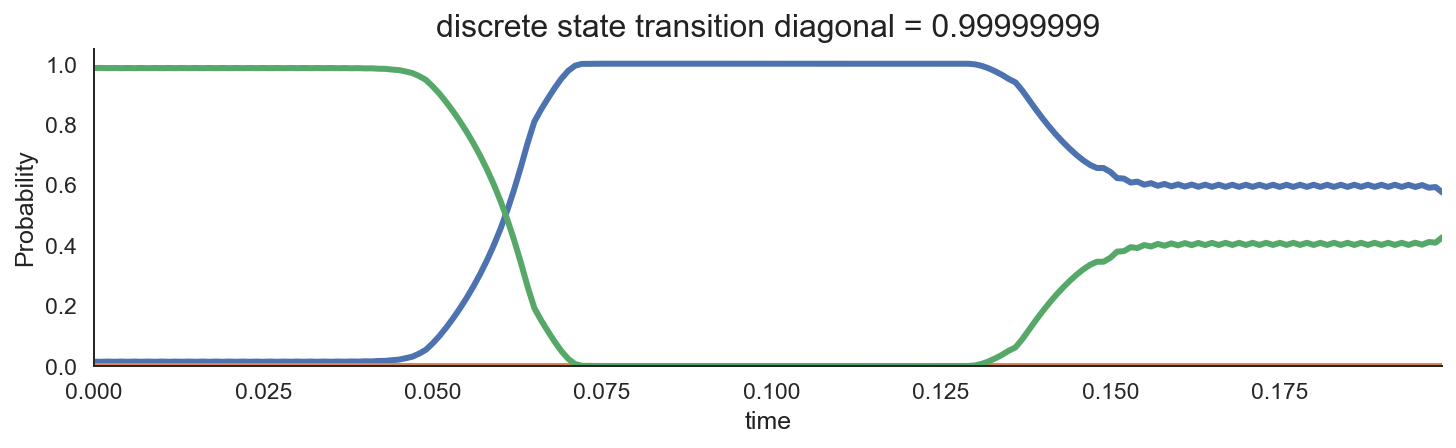

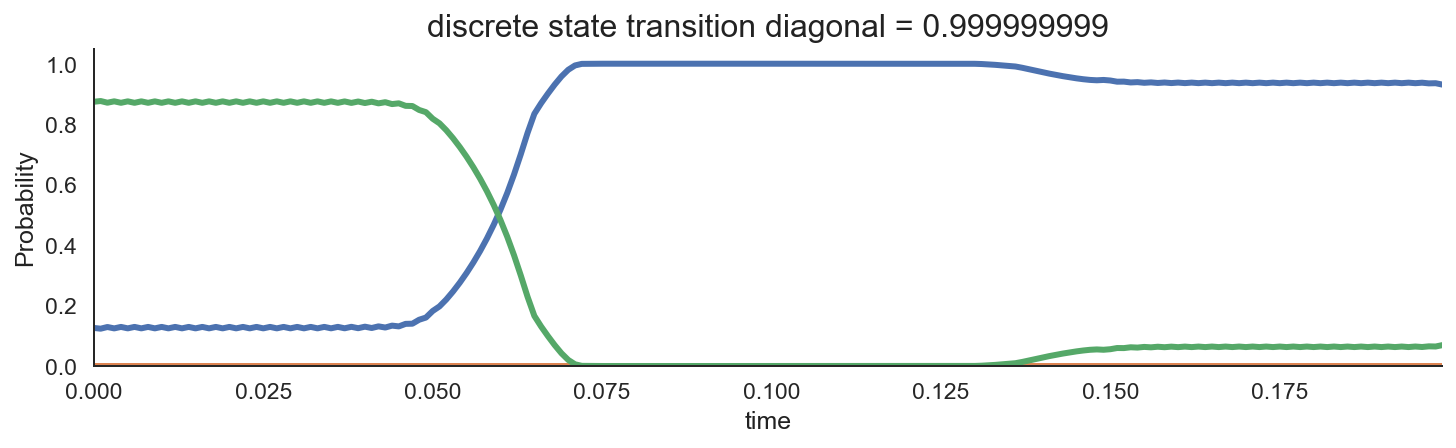

In [18]:
diags = [(1 - 10 ** -n) for n in range(2, 10)]

for diag in diags:
    classifier = SortedSpikesClassifier(movement_var=movement_var,
                                        replay_speed=120,
                                        spike_model_penalty=0.5,
                                        place_bin_size=np.sqrt(movement_var),
                                        discrete_transition_diag=diag)
    classifier.fit(linear_distance, spikes)
    results = classifier.predict(test_spikes, replay_time)
    plot_replay_probability(replay_time, results, diag)

### Not allowing transitions between states

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


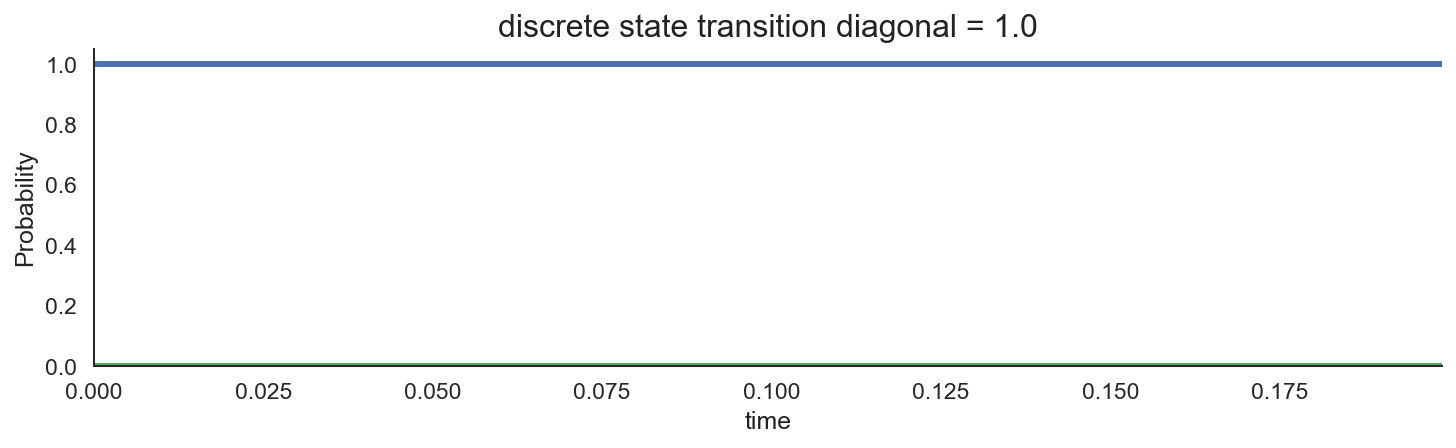

In [19]:
diag = 1.0

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var),
                                    discrete_transition_diag=diag)
classifier.fit(linear_distance, spikes)
results = classifier.predict(test_spikes, replay_time)
plot_replay_probability(replay_time, results, diag)